# Aprendizaje por refuerzo profundo - Proyecto del curso
Solución Reto 1 haciendo uso de aprendizaje por refuerzo profundo para el juego Battle Zone

**Docentes**: Fernando Lozano - Nicolás Cardozo

**Estudiantes**:

- Jose Mario Bogotá Melo

- Ana María López Arciniegas

Maestría en Inteligencia Artificial- Universidad de los Andes

## Importación de librerias

In [1]:
# ===============================================
# 🔧 Instalación de dependencias (Colab)
# ===============================================
# Núcleo RL y entornos Atari
!pip install -q "gymnasium[atari,accept-rom-license]" ale-py autorom
!pip install -q stable-baselines3 sb3-contrib    # SB3 + algoritmos extra (si los usas)

# Utilidades opcionales
!pip install -q opencv-python                     # Procesamiento de imágenes/video (opcional)

# Descarga e instalación de ROMs de Atari (requiere autorom instalado)
!AutoROM --accept-license -v

# ===============================================
# 📦 Imports principales
# ===============================================
import gymnasium as gym
import ale_py
import numpy as np
import matplotlib.pyplot as plt

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure, Logger, CSVOutputFormat, HumanOutputFormat
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_atari_env, make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecMonitor, VecVideoRecorder
from gymnasium.wrappers import TimeLimit

# Utilidades
from collections import deque
import cv2
import os, sys, math, random, pandas as pd
import time

# Registrar entornos ALE en Gymnasium (necesario en algunos Colab)
gym.register_envs(ale_py)

# Limpieza de salida tras instalación (estético)
from IPython.display import clear_output
clear_output()
print("✅ Entorno listo: Gymnasium + ALE + SB3 + ROMs de Atari.")


✅ Entorno listo: Gymnasium + ALE + SB3 + ROMs de Atari.


In [2]:
def make_dqn_battlezone(env):
    model = DQN(
        policy="CnnPolicy",               # CNN para observaciones tipo imagen (Atari)
        env=env,                          # entorno ya envuelto (frame stack, monitor, etc.)
        learning_rate=5e-5,               # LR más bajo para fine-tuning estable
        buffer_size=500_000,              # tamaño del replay buffer (experiencias)
        learning_starts=10_000,           # pasos antes de empezar a actualizar
        batch_size=64,                    # tamaño de lote al muestrear del buffer
        gamma=0.99,                       # factor de descuento
        target_update_interval=20_000,    # sincroniza red objetivo cada 20k pasos
        train_freq=4,                     # actualiza cada 4 pasos del entorno
        gradient_steps=1,                 # nº updates por cada “tick” de entrenamiento
        exploration_initial_eps=1.0,      # ε inicial (100% exploración)
        exploration_final_eps=0.02,       # ε final (2% exploración sostenida)
        exploration_fraction=0.20,        # decaimiento lineal de ε en 20% de los timesteps
        policy_kwargs=dict(dueling=True), # activa arquitectura Dueling
        verbose=0,
    )
    return model


In [3]:
# Callback personalizado para registrar las recompensas por episodio durante el entrenamiento
class RewardLoggerCallback(BaseCallback):
    def __init__(self, log_interval=50):
        super().__init__()
        self.episode_rewards = [] # Lista para almacenar las recomprensas por episodio
        self.log_interval = log_interval

    def _on_step(self) -> bool:
        # Verificar si hay información de los episodios en los infos proporcionados por el entorno
        for info in self.locals.get('infos', []):
            if 'episode' in info:
                reward_acu = info['episode']['r']
                self.episode_rewards.append(reward_acu)
                if len(self.episode_rewards) % self.log_interval == 0:
                    avg = np.mean(self.episode_rewards[-self.log_interval:])
                    print(f"[Episodio {len(self.episode_rewards)}]"
                          f"Recompensa promedio últimos episodios {self.log_interval}: {avg:.2f}")
        return True
# Guarda el replay buffer cada N steps
class SaveReplayBufferCallback(BaseCallback):
    def __init__(self, save_path, save_every=200_000):
        super().__init__()
        self.save_path = save_path
        self.save_every = save_every

    def _on_step(self) -> bool:
        if self.num_timesteps % self.save_every == 0:
            self.model.save_replay_buffer(self.save_path)
            print(f"[SB3] Replay buffer guardado en {self.save_path} @ {self.num_timesteps} steps")
        return True


class BattleZoneTrainer:
    def __init__(self, model_fn, total_timesteps=1_000_000, log_dir="./logs_bzone_v3", seed=0, resume_from=None):
        os.makedirs(log_dir, exist_ok=True)
        env = make_atari_env("ALE/BattleZone-v5", n_envs=1, seed=seed)
        env = VecFrameStack(env, n_stack=4) #apila 4 frames (historial)
        env.envs[0] = Monitor(env.envs[0], filename=os.path.join(log_dir, "monitor.csv")) #log de episodios
        self.env = env
        self.log_dir = log_dir

        # ⬇️ Cargar modelo si hay checkpoint, si no crear uno nuevo
        if resume_from and os.path.exists(resume_from):
            print(f"[Resume] Cargando modelo desde {resume_from}")
            self.model = DQN.load(resume_from, env=self.env, device="auto")
            # (Opcional) Cargar replay buffer si existe
            rb_path = os.path.join(log_dir, "replay_buffer.pkl")
            if os.path.exists(rb_path):
                self.model.load_replay_buffer(rb_path)
                print(f"[Resume] Replay buffer cargado desde {rb_path}")
        else:
            self.model = model_fn(self.env)

        self.callback = RewardLoggerCallback()
        self.total_timesteps = total_timesteps


    def train(self, save_path='dqn_battlezone'):
        self.model.learn(
            total_timesteps=self.total_timesteps,
            log_interval=100,
            callback=self.callback,
            reset_num_timesteps=False   # ⬅️ agrega esta línea
        )
        self.model.save(save_path)
        print("Entrenamiento completo, modelo guardado", save_path)
        rb_path = os.path.join(self.log_dir, "replay_buffer.pkl")
        self.model.save_replay_buffer(rb_path)
        print(f"Replay buffer guardado en {rb_path}")


    def plot_rewards(self):
        # Gráfica la evolución de las recompensas por episodio
        if not self.callback.episode_rewards:
            print("No reward data to plot")
            return
        plt.figure(figsize=(10,5))
        plt.plot(self.callback.episode_rewards, label='Recompensa por episodio')
        plt.xlabel('episodios')
        plt.ylabel('Recompensa')
        plt.title("Recompensas - entrenamiento sobre el tiempo")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    def generate_video(self, model_path="dqn_battlezone_v2.zip", out_dir="./output_v3", seed=0): # modificar max_steps
        os.makedirs(out_dir, exist_ok=True)

        model = DQN.load(model_path)

        # Mismo pipeline que entrenamiento
        env = make_atari_env("ALE/BattleZone-v5", n_envs=1, seed=seed)
        env = VecFrameStack(env, n_stack=4)

        # Envolver con grabador de video
        env = VecVideoRecorder(
            env,
            video_folder=out_dir,
            record_video_trigger=lambda step: step == 0,  # graba desde el inicio
            video_length=500
        )

        obs = env.reset()
        
        # NOOPs iniciales (opcional)
        for _ in range(10):
            obs, _, dones, _ = env.step(np.array([0], dtype=np.int64))
            if dones[0]:
                obs = env.reset()

        total_reward = 0.0

        # Ejecuta exactamente steps_to_record pasos, reseteando si el episodio termina
        for _ in range(500):
            action, _ = model.predict(obs, deterministic=True)
            if not isinstance(action, np.ndarray) or action.ndim == 0:
                action = np.array([int(action)], dtype=np.int64)
            obs, rewards, dones, _ = env.step(action)
            total_reward += float(rewards[0])
            if dones[0]:
                obs = env.reset()
    
        env.close()
        print(f"Video guardado en: {out_dir} | | Recompensa acumulada: {total_reward:.1f}")

        
        env.close

    def generate_training_video(self, out_dir="./output_v3", seed=0, seconds=8, mini_steps=20_000):
        os.makedirs(out_dir, exist_ok=True)
        steps_to_record = int(60 * seconds)
    
        # nuevo env solo para grabar mientras entrena un poco
        env_rec = make_atari_env("ALE/BattleZone-v5", n_envs=1, seed=seed)
        env_rec = VecFrameStack(env_rec, n_stack=4)
        env_rec = VecVideoRecorder(
            env_rec,
            video_folder=out_dir,
            record_video_trigger=lambda step: step == 0,
            video_length=steps_to_record
        )
    
        # conecta temporalmente el env grabador al modelo y entrena un poco
        self.model.set_env(env_rec)
        self.model.learn(total_timesteps=mini_steps, reset_num_timesteps=False)
        env_rec.close()
        print(f"[Video Entrenamiento] Guardado en {out_dir} | ~{seconds}s | pasos de mini-entrenamiento: {mini_steps}")  
    
        
    def evaluate(self, model_path, n_episodes=10, seed=0, deterministic=True):
        model = DQN.load(model_path)
    
        # Mismo pipeline que entrenamiento
        env = make_atari_env("ALE/BattleZone-v5", n_envs=1, seed=seed)
        env = VecFrameStack(env, n_stack=4)
    
        # 0% exploración en evaluación
        if hasattr(model, "exploration_rate"):
            model.exploration_rate = 0.0
    
        rewards = []
        for _ in range(n_episodes):
            obs = env.reset()
            ep_reward = 0.0
            done = False
            while not done:
                action, _ = model.predict(obs, deterministic=deterministic)
                if not isinstance(action, np.ndarray) or action.ndim == 0:
                    action = np.array([int(action)], dtype=np.int64)
                obs, r, dones, _ = env.step(action)
                ep_reward += float(r[0])
                done = bool(dones[0])
            rewards.append(ep_reward)
    
        env.close()
        avg = float(np.mean(rewards))
        std = float(np.std(rewards))
        print(f"[Eval] {n_episodes} episodios → Recompensa promedio = {avg:.2f} ± {std:.2f}")
        return avg, std, rewards



A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


[Resume] Cargando modelo desde dqn_battlezone_resume.zip
[Resume] Replay buffer cargado desde ./logs_bzone_v3/replay_buffer.pkl
[Episodio 50]Recompensa promedio últimos episodios 50: 4.32
[Episodio 100]Recompensa promedio últimos episodios 50: 4.52
[Episodio 150]Recompensa promedio últimos episodios 50: 3.78
[Episodio 200]Recompensa promedio últimos episodios 50: 3.88
[Episodio 250]Recompensa promedio últimos episodios 50: 3.88
[Episodio 300]Recompensa promedio últimos episodios 50: 5.02
[Episodio 350]Recompensa promedio últimos episodios 50: 4.76
[Episodio 400]Recompensa promedio últimos episodios 50: 3.68
[Episodio 450]Recompensa promedio últimos episodios 50: 4.06
[Episodio 500]Recompensa promedio últimos episodios 50: 3.54
[Episodio 550]Recompensa promedio últimos episodios 50: 4.18
[Episodio 600]Recompensa promedio últimos episodios 50: 4.06
[Episodio 650]Recompensa promedio últimos episodios 50: 2.98
[Episodio 700]Recompensa promedio últimos episodios 50: 4.52
[Episodio 750]Recom

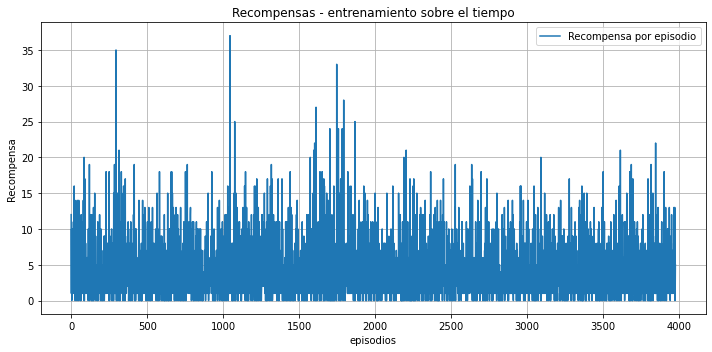

[Eval] 10 episodios → Recompensa promedio = 3.90 ± 4.30
Saving video to /mnt/disk/amlopeza/DRL/dev/output_v3/training/rl-video-step-0-to-step-480.mp4
MoviePy - Building video /mnt/disk/amlopeza/DRL/dev/output_v3/training/rl-video-step-0-to-step-480.mp4.
MoviePy - Writing video /mnt/disk/amlopeza/DRL/dev/output_v3/training/rl-video-step-0-to-step-480.mp4



MoviePy - Done !
MoviePy - video ready /mnt/disk/amlopeza/DRL/dev/output_v3/training/rl-video-step-0-to-step-480.mp4
[Video Entrenamiento] Guardado en ./output_v3/training | ~8s | pasos de mini-entrenamiento: 20000
Saving video to /mnt/disk/amlopeza/DRL/dev/output_v3/rl-video-step-0-to-step-500.mp4
MoviePy - Building video /mnt/disk/amlopeza/DRL/dev/output_v3/rl-video-step-0-to-step-500.mp4.
MoviePy - Writing video /mnt/disk/amlopeza/DRL/dev/output_v3/rl-video-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready /mnt/disk/amlopeza/DRL/dev/output_v3/rl-video-step-0-to-step-500.mp4
Video guardado en: ./output_v3 | | Recompensa acumulada: 18.0


In [4]:
if __name__ == "__main__":
    start_time = time.time()
    trainer = BattleZoneTrainer(
        model_fn=make_dqn_battlezone,
        total_timesteps=500_000,              # ⬅️ ahora 500k pasos adicionales
        log_dir="./logs_bzone_v3",
        seed=0,
        resume_from="dqn_battlezone_resume.zip"   # ⬅️ carga el último checkpoint guardado
    )
    trainer.train(save_path="dqn_battlezone_resume2.zip")  # ⬅️ guarda con otro nombre
    end_time = time.time()     
    elapsed = (end_time - start_time) / 60   # minutos
    print(f"⏱️ Tiempo de entrenamiento: {elapsed:.2f} minutos")

    trainer.plot_rewards()
    # Evaluación para el requisito de 10 partidas
    trainer.evaluate("dqn_battlezone_resume2.zip", n_episodes=10)
    #Videos durante entrenamiento y ya entrando
    trainer.generate_training_video(out_dir="./output_v3/training", seconds=8)
    trainer.generate_video(model_path="dqn_battlezone_resume2.zip")
